In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, LSTM,Embedding, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

In [2]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, LSTM,Embedding, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [3]:
def load_pickle(filename):
    obj = pickle.load(open(filename + '.pkl', 'rb'))
    return obj

In [4]:
tokenizer = load_pickle('tokenizer')
max_length = load_pickle('max_length')
vocab_size = len(tokenizer.word_index) + 1

In [5]:
def create_sequences(caption_list, tokenizer, max_length, vocab_size, encoding):
    x1 = []
    x2 = []
    y = []
    for caption in caption_list:
        sequences = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(sequences)):
            in_seq, out_seq = sequences[:i], sequences[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#                 print(in_seq, out_seq, encodings[name][0])
            x1.append(encoding)
            x2.append(in_seq)
            y.append(out_seq)
    
    return np.array(x1), np.array(x2), np.array(y)

In [6]:
def data_generator(cap_dic, encodings, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, caption_list in cap_dic.items():
            # retrieve the photo feature
            encoding = encodings[key][0]
            in_img, in_seq, out_word = create_sequences(caption_list,
                                                        tokenizer,
                                                        max_length,
                                                        vocab_size,
                                                        encoding)
            yield [in_img, in_seq], out_word

In [7]:
train_captions = load_pickle('train_captions')
train_img_encodings = load_pickle('train_img_encodings')
val_captions = load_pickle('val_captions')
val_img_encodings = load_pickle('val_img_encodings')

In [8]:
train_generator = data_generator(train_captions, train_img_encodings, tokenizer, max_length, vocab_size)
val_generator = data_generator(val_captions, val_img_encodings, tokenizer, max_length, vocab_size)
train_inputs, train_outputs = next(train_generator)
val_inputs, val_outputs = next(val_generator)
print(train_inputs[0].shape)
print(train_inputs[1].shape)
print(train_outputs.shape)
print(val_inputs[0].shape)
print(val_inputs[1].shape)
print(val_outputs.shape)

(58, 4096)
(58, 37)
(58, 7984)
(61, 4096)
(61, 37)
(61, 7984)


In [9]:
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [10]:
model = define_model(vocab_size, max_length)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 37, 256)      2043904     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                              

In [11]:
# train the model, run epochs manually and save after each epoch
epochs = 20
train_steps = len(train_captions)
val_steps = len(val_captions)
acc = []
val_acc = []
loss = []
val_loss = []

for i in range(epochs):
    # create the data generator
    generator = data_generator(train_captions, train_img_encodings, tokenizer, max_length, vocab_size)
    # fit for one epoch
    history = model.fit(train_generator, epochs=1, 
                        steps_per_epoch=train_steps, 
                        verbose=1, validation_data=(val_generator), 
                        validation_steps=val_steps)
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    # save model
    model.save('model_' + str(i) + '.h5')

6473/6473 [==============================] - 977s 150ms/step - loss: 4.1318 - val_loss: 3.6123


D:\Anaconda\envs\image_caption\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6473/6473 [==============================] - 993s 153ms/step - loss: 2.7174 - val_loss: 3.8237


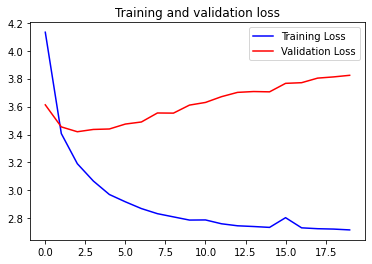

In [39]:
plt.plot([epoch for epoch in range(epochs )], loss, 'b', label='Training Loss')
plt.plot([epoch for epoch in range(epochs )], val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
def generate_captions(model, img_encoding, tokenizer, max_length):
    
    caption = 'sos'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([caption])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([img_encoding, seq])
        yhat = np.argmax(yhat)
        pred_word = idx_word_dic[yhat]
        if pred_word == None:
            break
        caption += " " + pred_word
        if pred_word == 'eos':
            break
    return caption

In [9]:
def evaluate_model(model, cap_dic, img_encodings, tokenizer, max_length):
    
    actual = []
    prediction = []

    for name, cap_list in cap_dic.items():
        img_encoding = img_encodings[name]
        predict_caption = generate_captions(model, img_encoding, tokenizer, max_length)
        prediction.append(predict_caption.split())
        actual.append([caption.split() for caption in cap_list])
    
    bleu_1 = corpus_bleu(actual, prediction, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, prediction, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(actual, prediction, weights=(0.3, 0.3, 0.3, 0))
    bleu_4 = corpus_bleu(actual, prediction, weights=(0.25, 0.25, 0.25, 0.25))
    print('BLEU-1: %f' % bleu_1)
    print('BLEU-2: %f' % bleu_2)
    print('BLEU-3: %f' % bleu_3)
    print('BLEU-4: %f' % bleu_4)
    
    return bleu_1,bleu_2, bleu_3, bleu_4

In [12]:
train_img_encodings = load_pickle('train_img_encodings')
val_img_encodings = load_pickle('val_img_encodings')
idx_word_dic = load_pickle('idx_word_dic')
model = load_model('model_5.h5')

In [13]:
evaluate_model(model, train_captions, train_img_encodings, tokenizer, max_length)

BLEU-1: 0.593264
BLEU-2: 0.388168
BLEU-3: 0.282108
BLEU-4: 0.155887


(0.5932640848188869,
 0.38816833454536365,
 0.282107744271803,
 0.1558868236862933)

In [15]:
evaluate_model(model, val_captions, val_img_encodings, tokenizer, max_length)

BLEU-1: 0.589280
BLEU-2: 0.379054
BLEU-3: 0.271602
BLEU-4: 0.146975


(0.5892802915274825,
 0.3790537404064232,
 0.271601605915663,
 0.14697464894466833)